# Synthetic Features and Outliers

### Goals
-  create synthetic feature that is ratio of two other features
-  use new feature as input to linear regression
-  improve effectiveness of model by identifying and clipping outliers of input data

In [15]:
import math

from matplotlib import cm
from matplotlib import gridspec

from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

In [34]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [35]:
# provided boiler plate

# retrieve data
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8585,-118.5,34.3,33.0,1975.0,271.0,801.0,287.0,7.8,379.6
13806,-122.0,37.3,27.0,3340.0,451.0,1220.0,447.0,8.8,500.0
14464,-122.1,37.4,42.0,2390.0,462.0,1146.0,468.0,6.3,397.4
2572,-117.7,34.0,15.0,3393.0,653.0,2039.0,611.0,3.9,151.0
12018,-121.4,38.5,4.0,20982.0,3392.0,10329.0,3086.0,4.4,130.6


In [36]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Train a linear regression model on one feature
    
    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Num batch size to be fed into model
        shuffle: True or False to randomize data
        num_epochs: Num of epochs to repeat over data.  None = indefinitely
    Returns:
        Tuple (features, labels) for next data batch
    """
    
    # convert pandas data into dict of numpy arrays
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    # construct dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # shuffle data if necessary
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    
    # return next batch
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [37]:
def train_model(learning_rate, steps, batch_size, input_feature):
    """
    Train linear regression model
    
    Args:
        learning_rate: 'float', the learning rate
        steps: 'int', num training steps, which consists of single forward and backward pass through
        batch_size: 'int' batch size
        input_features: 'string' value for column from the housing data to be used as a feature
    Returns:
        Pandas 'DataFrame' containing targets and the corresponding predictions done after training
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    # get feature(s) / labels
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    my_label = 'median_house_value'
    targets = california_housing_dataframe[my_label].astype('float32')
    
    # create input fn
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # create feature clm
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # create linear regressor obj
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns, optimizer=my_optimizer)
    
    # set up plot state of model each period
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # train model
    print("Training model...")
    print("RMSE (training):")
    root_mean_squared_errors = []
    for period in range(0, periods):
        # train
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        # make predictions
        predictions = linear_regressor.predict(input_fn=predict_training_input_fn,)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # compute loss
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(targets, predictions))
        
        # print loss
        print("    period %02d: %0.2f" % (period, root_mean_squared_error))
        # append loss metrics
        root_mean_squared_errors.append(root_mean_squared_error)
        # finally, track weights and biases over time
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
        
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    
    print("Model training finished")
    
    # output a graph of loss metrics over periods
    plt.subplot(1,2,2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title('Root Mean Squared Error (RMSE) vs Periods')
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # create a table with calibration data
    calibration_data = pd.DataFrame()
    calibration_data['predictions'] = pd.Series(predictions)
    calibration_data['targets'] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RMSE (training): %0.2f" % root_mean_squared_error)
    
    return calibration_data

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphd_sor6c', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc9519004e0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (training):
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmphd_sor6c/model.ckpt.
INFO:tensorflow:loss = 298041.2, step = 1
INFO:tensorflow:Saving checkpoints for 50 into /tmp/tmphd_sor6c/model.ckpt.
INFO:tensorflow:Loss for final step: 202961.84.
INFO:tensorflow:Restoring parameters from /tmp/tmphd_sor6c/model.ckpt-50
    period 00: 231.60
INFO:t

,predictions,targets
count,17000.000000,17000.000000
mean,51.825691,207.300919
std,28.995615,115.983765
min,3.750753,14.999000
25%,29.850710,119.400002
50%,45.100536,180.399994
75%,66.250298,265.000000
max,124.999886,500.001007


Final RMSE (training): 178.15


,predictions,targets
0,38.025620,66.900002
1,60.950359,80.099998
2,98.399940,85.699997
3,74.900200,73.400002
4,41.275581,65.500000
5,19.700825,74.000000
6,18.050840,82.400002
7,38.900608,48.500000
8,40.625587,58.400002
9,45.550529,48.099998


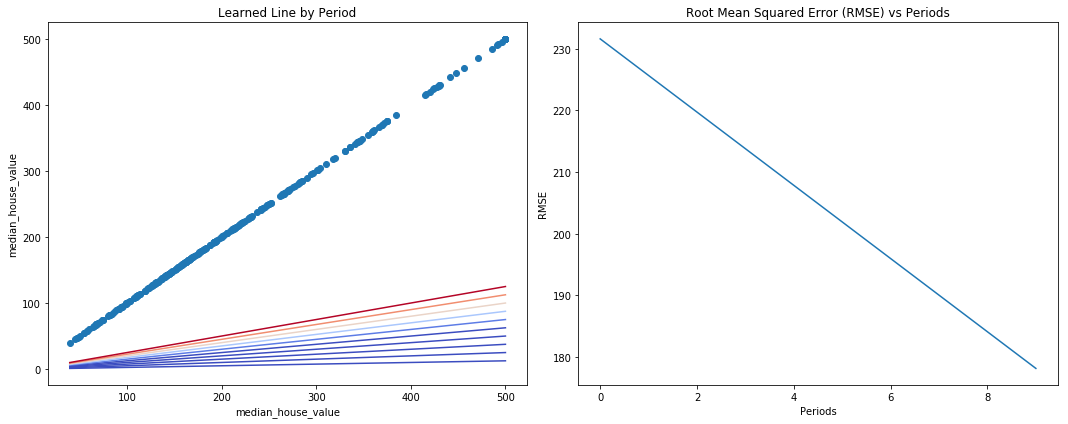

In [19]:
train_model(.0001, steps=500, batch_size=5, input_feature='median_house_value')

## Task 1: Try a Synthetic Feature

In [38]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [39]:
california_housing_dataframe["rooms_per_person"] = (california_housing_dataframe['total_rooms'] / california_housing_dataframe['population'])
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3,2.0
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0,1.2
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0,0.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4,1.5
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4,1.9
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0,2.3
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0,55.2


Training model...
RMSE (training):
    period 00: 212.74
    period 01: 190.45
    period 02: 169.66
    period 03: 152.48
    period 04: 140.69
    period 05: 133.66
    period 06: 131.11
    period 07: 130.71
    period 08: 131.73
    period 09: 132.04
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,197.5,207.3
std,90.8,116.0
min,45.0,15.0
25%,161.8,119.4
50%,194.4,180.4
75%,222.1,265.0
max,4333.0,500.0


Final RMSE (training): 132.04


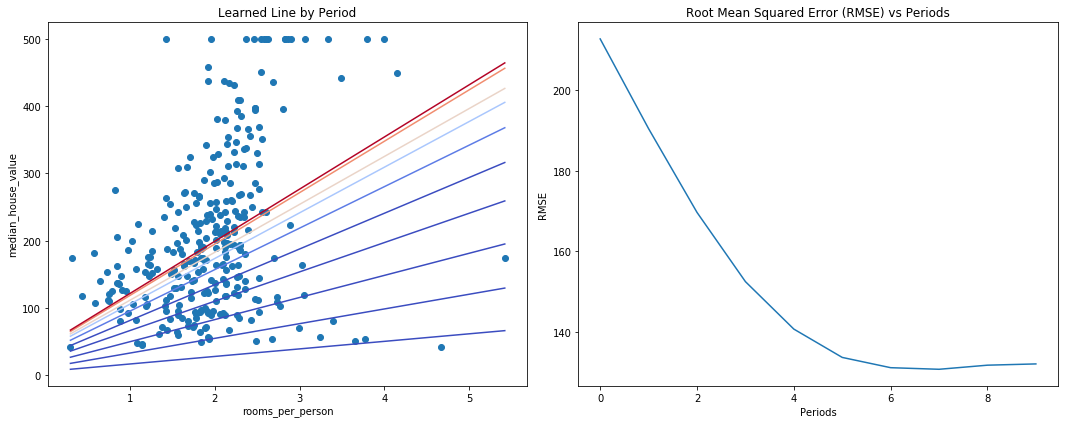

In [41]:
# train with synthetic feature
calibration_data = train_model(
    learning_rate=0.05,
    steps=500,
    batch_size=5,
    input_feature="rooms_per_person"
)

In [42]:
calibration_data

pandas.core.frame.DataFrame